In [13]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb


# Load configuration and keep necessary
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_PATH = Path(r"C:\Probook\E\AI\Projects\Data Science\Airbnb Price Prediction\Data\AB_US_2020.csv")

COLUMNS = [
    "id", "latitude", "longitude", "room_type", "price",
    "minimum_nights", "number_of_reviews", "reviews_per_month",
    "calculated_host_listings_count", "availability_365", "city"
]

In [14]:
# loading the dataset with only the required columns.

print("\n[Load] Reading dataset...")
df = pd.read_csv(DATA_PATH, usecols=COLUMNS, low_memory=False)
print(f"[Load] Shape: {df.shape}")
print(f"[Load] Missing values summary:\n{df.isna().sum()}\n")


[Load] Reading dataset...
[Load] Shape: (226030, 11)
[Load] Missing values summary:
id                                    0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 48602
calculated_host_listings_count        0
availability_365                      0
city                                  0
dtype: int64



In [15]:
# cleaning steps.

before = len(df)
df = df.dropna(subset=["price", "latitude", "longitude", "room_type", "city"]).copy()
df = df[(df["price"] > 10) & (df["price"] < 5000)].copy()
df["reviews_per_month"] = df["reviews_per_month"].fillna(0)

# Compress the long tail of rare cities into a single 'Other' category.
top_cities = df["city"].value_counts().nlargest(20).index
df.loc[~df["city"].isin(top_cities), "city"] = "Other"

print(f"[Clean] Removed rows: {before - len(df)} | Remaining: {len(df)}")


[Clean] Removed rows: 666 | Remaining: 225364



[EDA] Highest-median-price cities:
city
Clark County       141.0
Nashville          150.0
Twin Cities MSA    150.0
Hawaii             187.0
Rhode Island       200.0
Name: price, dtype: float64


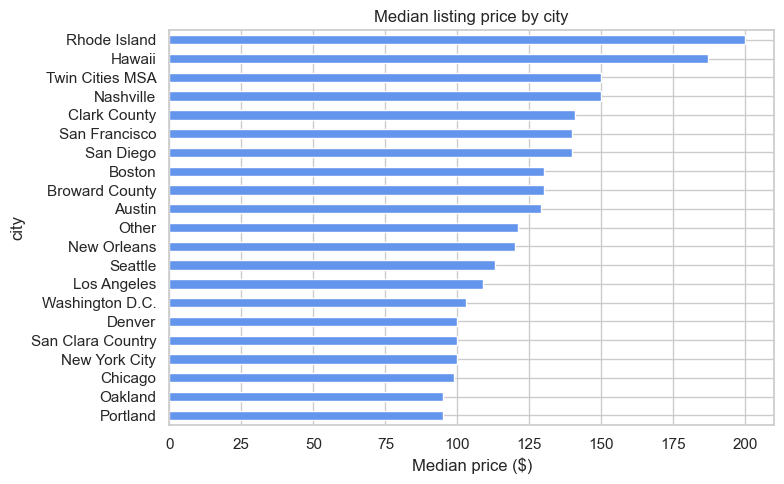

In [16]:
# how prices differ between cities.

print("\n[EDA] Highest-median-price cities:")
medians = df.groupby("city")["price"].median().sort_values()
print(medians.tail(5))

# Optional visualization — harmless to skip if running headless.
try:
    medians.plot(kind="barh", color="cornflowerblue")
    plt.title("Median listing price by city")
    plt.xlabel("Median price ($)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"[EDA] Plot skipped ({e})")

In [17]:
# Define which features will be used and log-transform the target.

df["price_log"] = np.log1p(df["price"])

NUM_COLS = [
    "minimum_nights", "number_of_reviews", "reviews_per_month",
    "calculated_host_listings_count", "availability_365", "latitude", "longitude"
]
CAT_COLS = ["room_type", "city"]

# Simple and transparent encoding of categorical variables.
X_num = df[NUM_COLS].copy()
X_cat = pd.get_dummies(df[CAT_COLS], drop_first=True)
X = pd.concat([X_num, X_cat], axis=1)
y = df["price_log"].values

print(f"\n[Features] X shape: {X.shape} | y length: {len(y)}")


[Features] X shape: (225364, 30) | y length: 225364


In [18]:
# Split the dataset into training and testing sets.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)
print(f"[Split] Train: {X_train.shape} | Test: {X_test.shape}")


[Split] Train: (180291, 30) | Test: (45073, 30)


In [20]:
# Standardize numeric features 
scaler = StandardScaler()

# Work on copies so the original frames remain clean
X_train = X_train.copy()
X_test = X_test.copy()

# Force numeric columns to float32 before scaling
X_train[NUM_COLS] = X_train[NUM_COLS].astype(np.float32)
X_test[NUM_COLS]  = X_test[NUM_COLS].astype(np.float32)

# Apply standardization safely
X_train.loc[:, NUM_COLS] = scaler.fit_transform(X_train[NUM_COLS])
X_test.loc[:,  NUM_COLS]  = scaler.transform(X_test[NUM_COLS])

In [21]:
# Configure and train the XGBoost model.

params = dict(
    objective="reg:squarederror",
    eval_metric="rmse",
    learning_rate=0.08,
    max_depth=6,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=4,
    verbosity=0
)
model = xgb.XGBRegressor(**params)

print("\n[Train] Training XGBoost model...")
model.fit(X_train, y_train, verbose=False)


[Train] Training XGBoost model...


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


In [22]:
# Evaluate the model on the test set.

y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
mae  = float(mean_absolute_error(y_true, y_pred))
r2   = float(r2_score(y_true, y_pred))

print(f"[Test] RMSE=${rmse:,.2f} | MAE=${mae:,.2f} | R²={r2:.3f}")

[Test] RMSE=$235.04 | MAE=$87.45 | R²=0.328


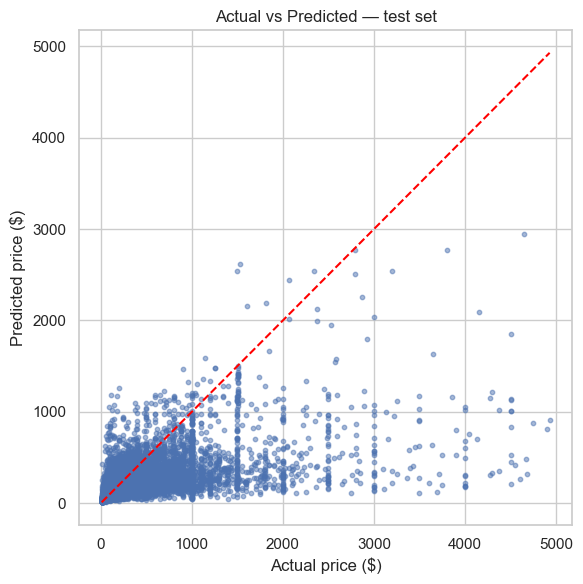

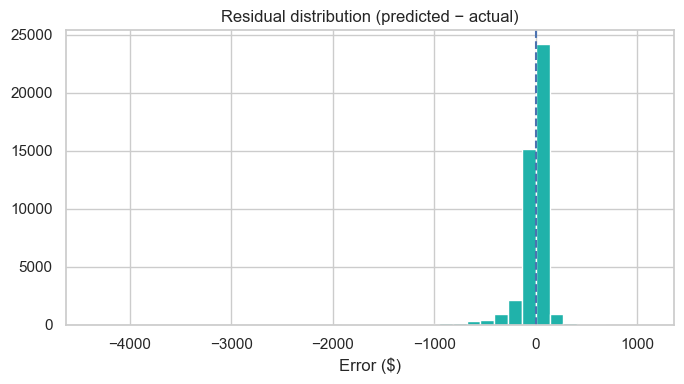

In [23]:
# Visualization

try:
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, s=10, alpha=0.5)
    low, high = float(min(y_true.min(), y_pred.min())), float(max(y_true.max(), y_pred.max()))
    plt.plot([low, high], [low, high], "--", color="red")
    plt.xlabel("Actual price ($)")
    plt.ylabel("Predicted price ($)")
    plt.title("Actual vs Predicted — test set")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.hist(y_pred - y_true, bins=40, color="lightseagreen")
    plt.axvline(0, linestyle="--")
    plt.title("Residual distribution (predicted − actual)")
    plt.xlabel("Error ($)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"[Plot] Skipped due to environment: {e}")


In [24]:
# Save the predictions
output = pd.DataFrame({"ActualPrice": y_true, "PredictedPrice": y_pred})
output_file = "Airbnb_XGB_Baseline_Results.csv"
output.to_csv(output_file, index=False)
print(f"[Save] File written: {output_file}")

# Optionally, export the trained model if needed later.
# model.save_model("airbnb_xgb_baseline.json")

[Save] File written: Airbnb_XGB_Baseline_Results.csv
